In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF

from PIL import Image
import cv2
import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")


Sử dụng thiết bị: cpu


In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  
        
        if self.transform:

            seed = torch.randint(0, 2**32, (1,)).item()
            
            torch.manual_seed(seed)
            image = self.transform(image)
            
            torch.manual_seed(seed)
            mask = self.transform(mask)
        
        # Chuyển mask thành nhị phân: 0 hoặc 1
        mask = (mask > 0.5).float()
        
        return image, mask

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [6]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Điều chỉnh kích thước để ghép nối
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                     diffY // 2, diffY - diffY // 2])
        
        # Ghép nối
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # Đường xuống
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        
        # Đường lên
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        
        # Lớp đầu ra
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Đường xuống
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Đường lên với skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outc(x)
        x = self.sigmoid(x)
        
        return x

In [16]:
import torch
from torch import nn

model = UNet(n_channels=3, n_classes=1)
print(model)  # In cấu trúc mô hình

# In tổng số lượng tham số và tham số có thể học được
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTổng số tham số: {total_params:,}")
print(f"Số tham số có thể huấn luyện: {trainable_params:,}")

for name, param in model.named_parameters():
    print(f"{name:50s} | shape: {tuple(param.shape)} | requires_grad: {param.requires_grad}")


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [9]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCELoss(weight=weight, size_average=size_average)
        
    def forward(self, inputs, targets, smooth=1):
        # BCE Loss
        bce_loss = self.bce(inputs, targets)
        
        # Dice Loss
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        return bce_loss + dice_loss


In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    
    for images, masks in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        
        # Tính loss
        loss = criterion(outputs, masks)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Tính toán độ chính xác
        predicted_masks = (outputs > 0.5).float()
        accuracy = (predicted_masks == masks).float().mean()
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
    
    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [11]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_accuracy = 0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            # Tính loss
            loss = criterion(outputs, masks)
            
            # Tính toán độ chính xác
            predicted_masks = (outputs > 0.5).float()
            accuracy = (predicted_masks == masks).float().mean()
            
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()
    
    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [12]:
def run_segmentation_model(data_dir='E:/HS/May2025/BT_01', img_size=256, batch_size=8, epochs=25, learning_rate=0.001):
    
    images_dir = os.path.join(data_dir, 'data')
    masks_dir = os.path.join(data_dir, 'mask')
    
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
    mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
    
    # Chia tập train/test theo tỉ lệ 80/20
    X_train, X_test, y_train, y_test = train_test_split(
        image_files, mask_files, test_size=0.2, random_state=42
    )
    
    print(f"Số lượng ảnh huấn luyện: {len(X_train)}")
    print(f"Số lượng ảnh kiểm thử: {len(X_test)}")
    
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    
    # Tạo dataset
    train_dataset = SegmentationDataset(X_train, y_train, transform=transform)
    test_dataset = SegmentationDataset(X_test, y_test, transform=transform)
    
    # Tạo dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Khởi tạo mô hình
    model = UNet(n_channels=3, n_classes=1).to(device)
    
    # Định nghĩa loss và optimizer
    criterion = BCEDiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Lưu lịch sử huấn luyện
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': []
    }
    
    # Huấn luyện
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Huấn luyện một epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Đánh giá trên tập test
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        
        # Lưu lịch sử
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title('Loss qua các epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['test_accuracy'], label='Test Accuracy')
    plt.title('Accuracy qua các epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()
    
    # Lưu mô hình
    torch.save(model.state_dict(), 'unet_binary_segmentation.pth')
    print("Đã lưu mô hình tại unet_binary_segmentation.pth")
    
    return model, history

In [13]:
def visualize_predictions(model, test_loader, num_samples=10):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            images = images.to(device)
            masks = masks.to(device)
            
            # Đưa qua mô hình
            outputs = model(images)
            predicted_masks = (outputs > 0.5).float()
            
            image = images[0].cpu().permute(1, 2, 0).numpy()
            true_mask = masks[0].cpu().squeeze().numpy()
            pred_mask = predicted_masks[0].cpu().squeeze().numpy()
            
            # Hiển thị
            axes[i, 0].imshow(image)
            axes[i, 0].set_title('Ảnh gốc')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(true_mask, cmap='gray')
            axes[i, 1].set_title('Mask thực tế')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_mask, cmap='gray')
            axes[i, 2].set_title('Mask dự đoán')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

c:\Users\OS\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Số lượng ảnh huấn luyện: 160
Số lượng ảnh kiểm thử: 40
Epoch 1/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.7841, Train Acc: 0.8312
Test Loss: 1.3077, Test Acc: 0.6615
Epoch 2/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Train Loss: 0.5475, Train Acc: 0.8992
Test Loss: 1.0343, Test Acc: 0.8306
Epoch 3/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Train Loss: 0.5167, Train Acc: 0.8952
Test Loss: 0.5001, Test Acc: 0.9017
Epoch 4/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Train Loss: 0.4653, Train Acc: 0.9062
Test Loss: 0.4264, Test Acc: 0.9063
Epoch 5/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Train Loss: 0.4627, Train Acc: 0.9045
Test Loss: 0.3863, Test Acc: 0.9121
Epoch 6/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Train Loss: 0.4296, Train Acc: 0.9109
Test Loss: 0.4264, Test Acc: 0.9079
Epoch 7/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Train Loss: 0.4293, Train Acc: 0.9103
Test Loss: 0.3715, Test Acc: 0.9134
Epoch 8/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Train Loss: 0.4201, Train Acc: 0.9123
Test Loss: 0.4897, Test Acc: 0.8709
Epoch 9/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.4037, Train Acc: 0.9172
Test Loss: 0.4719, Test Acc: 0.8786
Epoch 10/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.4297, Train Acc: 0.9144
Test Loss: 0.4881, Test Acc: 0.8921
Epoch 11/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.4170, Train Acc: 0.9128
Test Loss: 0.3823, Test Acc: 0.9197
Epoch 12/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Train Loss: 0.3909, Train Acc: 0.9187
Test Loss: 0.3373, Test Acc: 0.9274
Epoch 13/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Train Loss: 0.4355, Train Acc: 0.9090
Test Loss: 0.3797, Test Acc: 0.9190
Epoch 14/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.4342, Train Acc: 0.9077
Test Loss: 0.3407, Test Acc: 0.9297
Epoch 15/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Train Loss: 0.4017, Train Acc: 0.9202
Test Loss: 0.3530, Test Acc: 0.9221
Epoch 16/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Train Loss: 0.3744, Train Acc: 0.9237
Test Loss: 0.5371, Test Acc: 0.8624
Epoch 17/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Train Loss: 0.3341, Train Acc: 0.9306
Test Loss: 0.3575, Test Acc: 0.9283
Epoch 18/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.3945, Train Acc: 0.9176
Test Loss: 0.3218, Test Acc: 0.9305
Epoch 19/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Train Loss: 0.3362, Train Acc: 0.9317
Test Loss: 0.2687, Test Acc: 0.9419
Epoch 20/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Train Loss: 0.3106, Train Acc: 0.9349
Test Loss: 0.5582, Test Acc: 0.8776
Epoch 21/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.3236, Train Acc: 0.9338
Test Loss: 0.2880, Test Acc: 0.9310
Epoch 22/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Train Loss: 0.3983, Train Acc: 0.9171
Test Loss: 0.3286, Test Acc: 0.9287
Epoch 23/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.3673, Train Acc: 0.9240
Test Loss: 0.4019, Test Acc: 0.9147
Epoch 24/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Train Loss: 0.3541, Train Acc: 0.9257
Test Loss: 0.4256, Test Acc: 0.9067
Epoch 25/25


Evaluating: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Train Loss: 0.3935, Train Acc: 0.9193
Test Loss: 0.3180, Test Acc: 0.9325


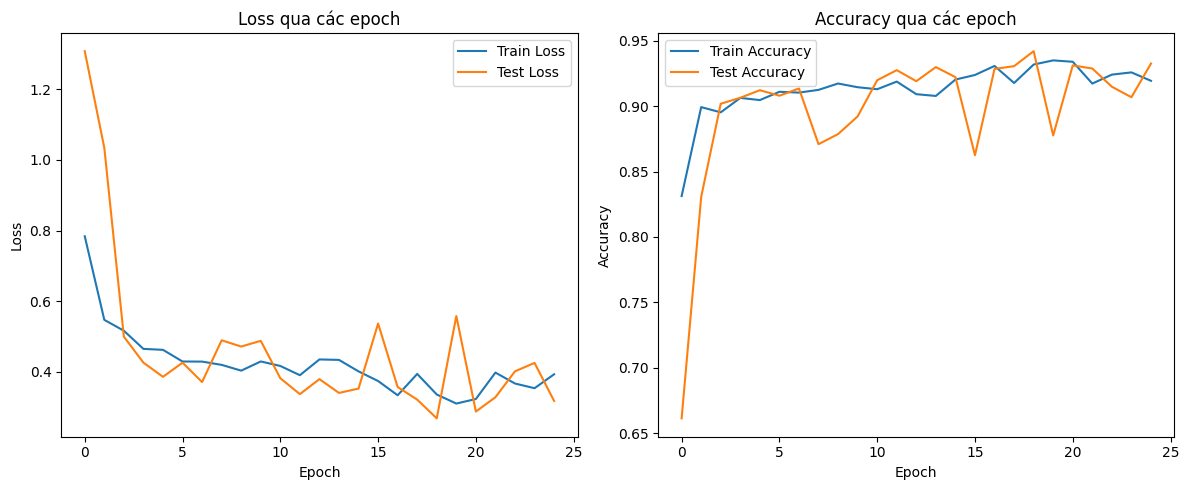

Đã lưu mô hình tại unet_binary_segmentation.pth


In [67]:
model, history = run_segmentation_model(
        data_dir='E:/HS/May2025/BT_01',
        img_size=256,
        batch_size=8,
        epochs=25,
        learning_rate=0.001
    )

In [80]:
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

In [81]:
images_dir = os.path.join('E:/HS/May2025/BT_01', 'data')
masks_dir = os.path.join('E:/HS/May2025/BT_01', 'mask')

In [82]:
image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

In [83]:
_, X_test, _, y_test = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

In [84]:
test_dataset = SegmentationDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

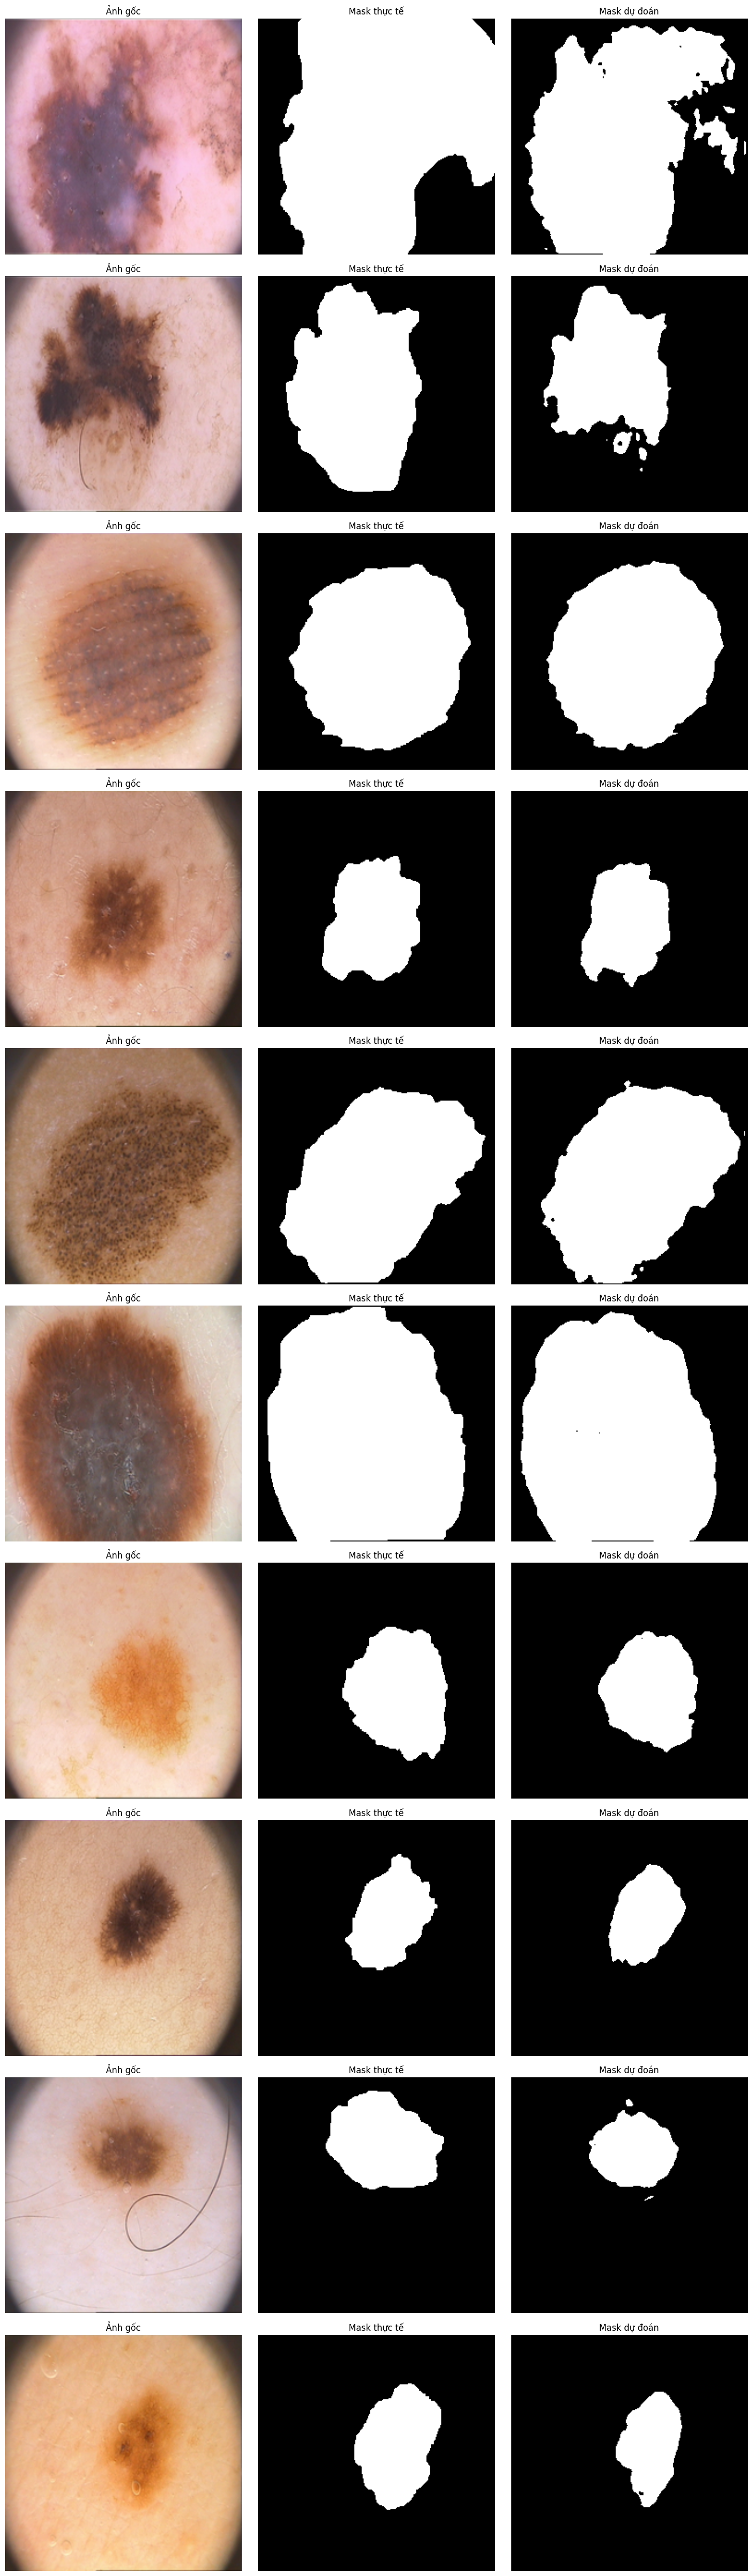

In [85]:
visualize_predictions(model, test_loader, num_samples=10)